# Importing data

In [1]:
import pandas as pd

In [2]:
routes_df = pd.read_csv("data/routes.csv")
airports_df = pd.read_csv("data/airports.csv")

In [3]:
airports_by_iata_df = airports_df.groupby("IATA")

In [4]:
airports_by_longtitude_df = airports_df.groupby("Longitude")
airports_by_lattitude_df = airports_df.groupby("Latitude")

# Creating a directed multigraph

In [5]:
import networkx as nx

In [6]:
airport_nodes = list(airports_by_iata_df.groups)

In [7]:
#Ordering matches source and destination airport.
airport_src = list(routes_df["Source airport"])
airport_dest = list(routes_df["Destination airport"])

In [8]:
airport_routes_digraph = nx.MultiDiGraph()

airport_routes_digraph.add_nodes_from(airport_nodes)

#Due to some routes having an invalid source/destination, due to the airport not existing
#in the airport database, these routes are removed.
edges = [(airport_src[i],airport_dest[i]) for i in range(len(airport_src))
        if airport_src[i] in airport_nodes and airport_dest[i] in airport_nodes]

airport_routes_digraph.add_edges_from(edges);

# Plotting the graph

In [9]:
import matplotlib.pyplot as plt

In [10]:
def getLongitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Longitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

def getLatitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Latitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0


In [11]:
positions = {}

for node in airport_routes_digraph.nodes:
    positions.update({node:(getLongitudeForIATA(airports_df,node),getLatitudeForIATA(airports_df,node))})    


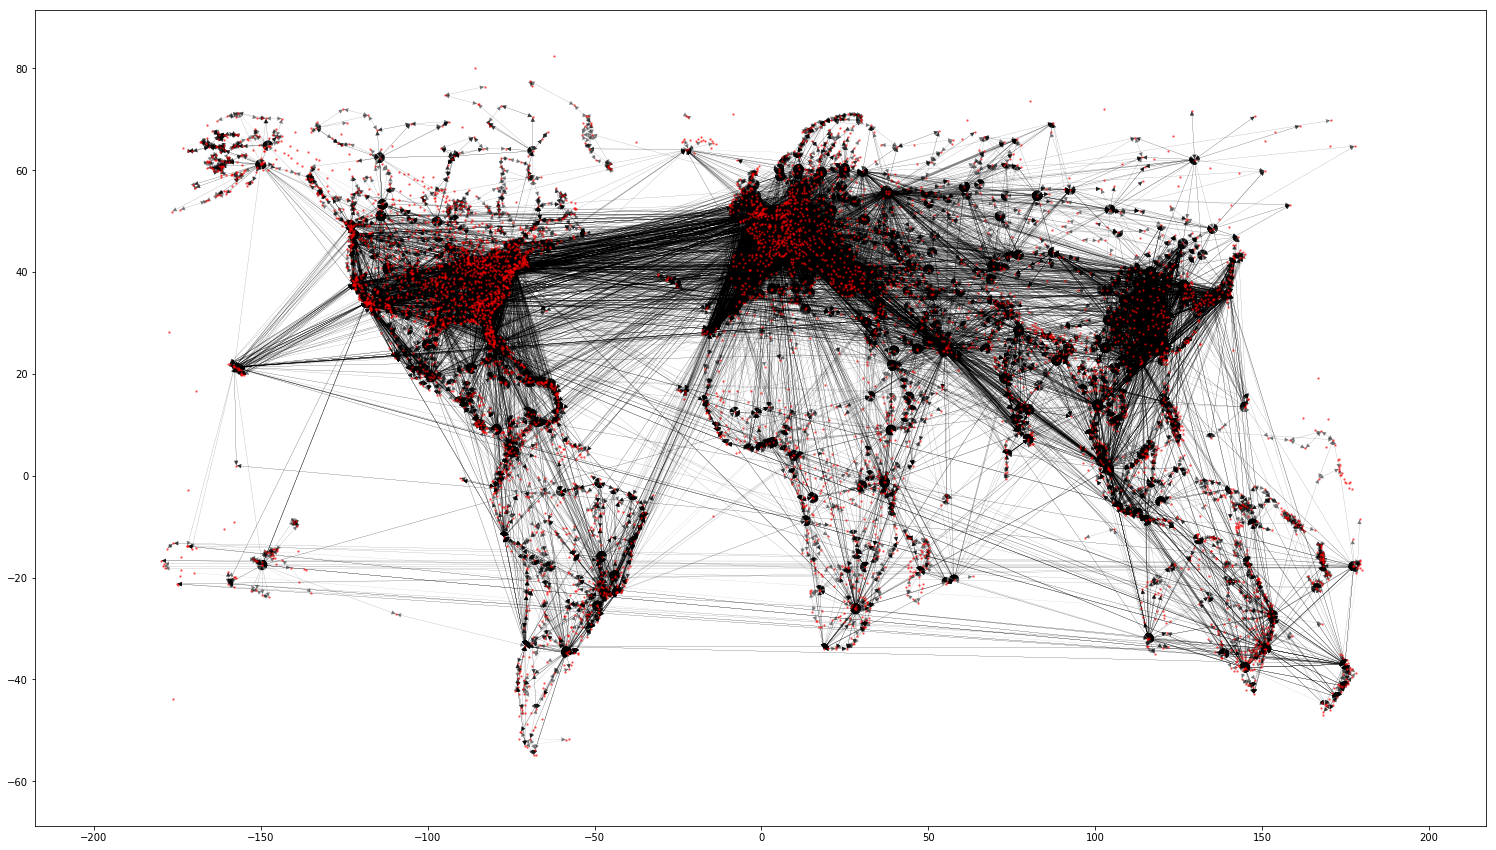

In [12]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))

fig.savefig("output/airportgraph.png", transparent=True)

In [13]:
len(airport_routes_digraph.nodes)

5634

In [14]:
len(airport_routes_digraph.edges)

65836

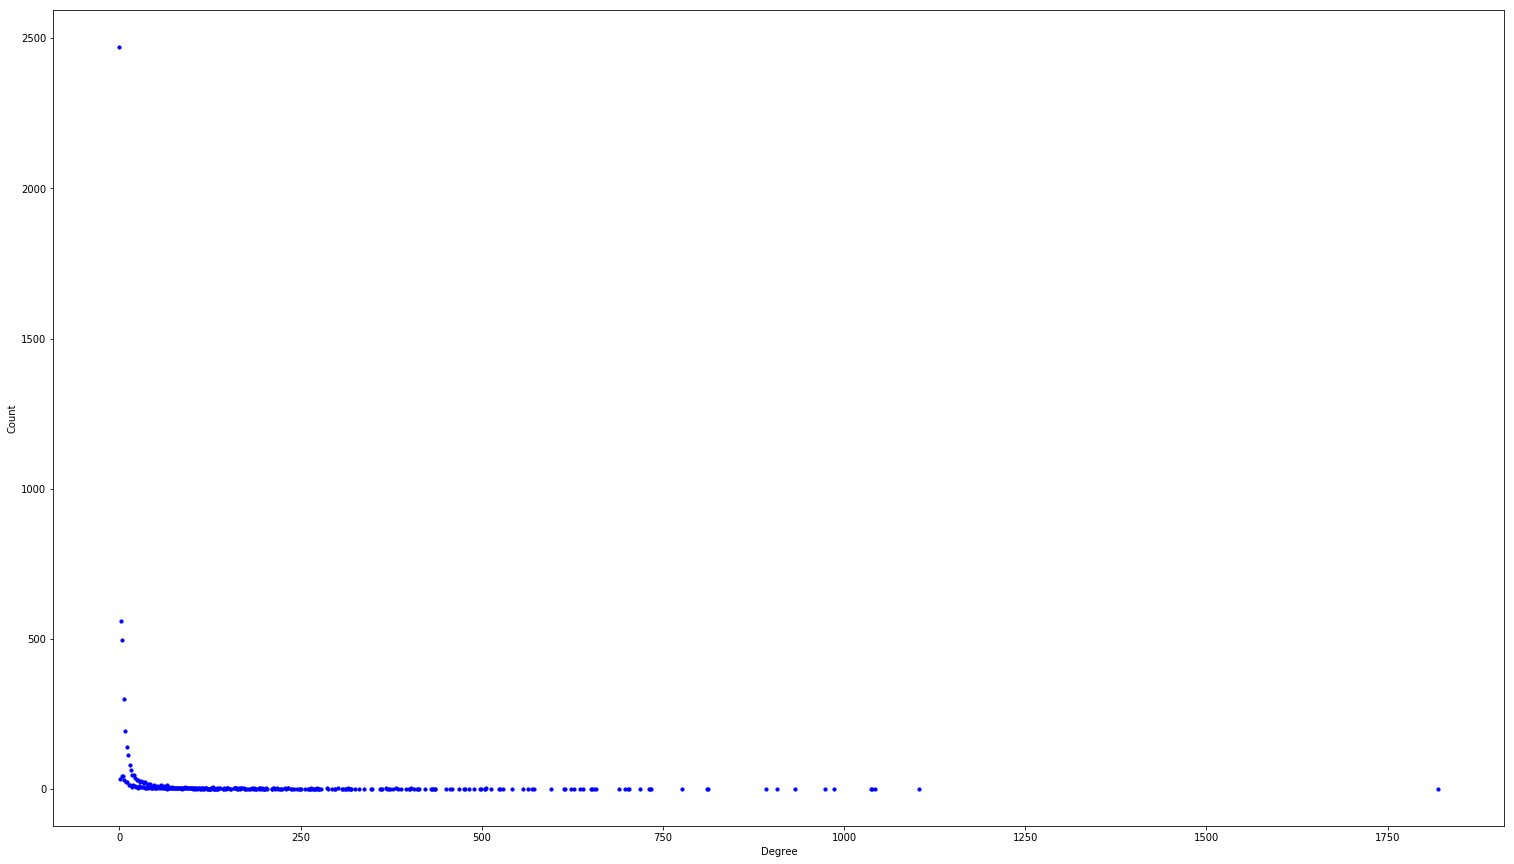

In [15]:
import collections

degreeforeach = sorted([d for n,d in airport_routes_digraph.degree], reverse=True)
degreeCount = collections.Counter(degreeforeach)
degrees, count = zip(*degreeCount.items())
fig = plt.figure(figsize=(26,15))
plt.scatter(degrees, count, s=10, color='b')
plt.ylabel("Count")
plt.xlabel("Degree")

fig.savefig('output/regularplot.png', transparent=True)

<Figure size 432x288 with 0 Axes>

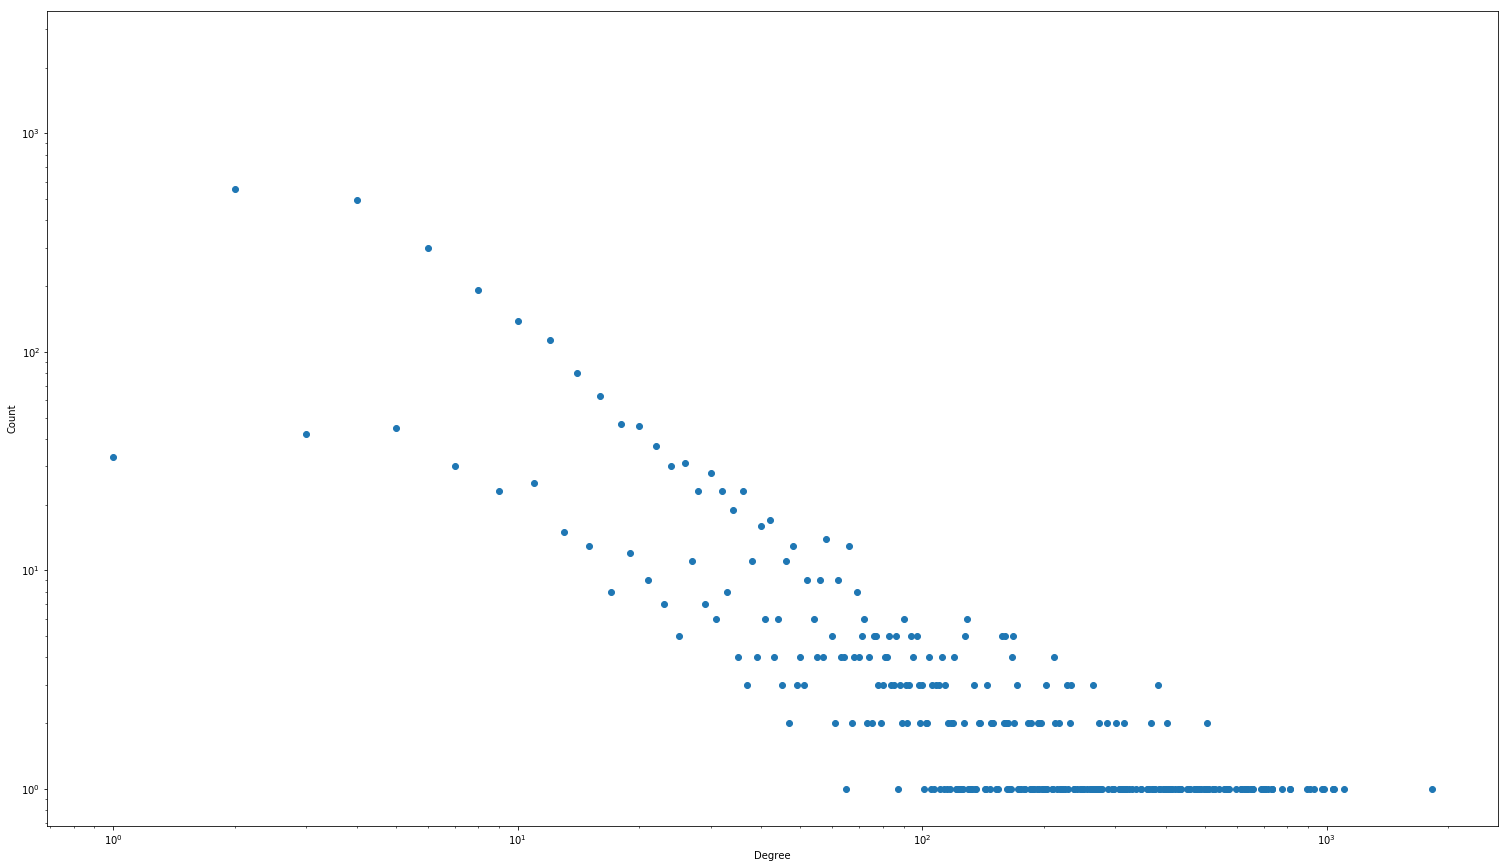

In [16]:
plt.clf()
fig = plt.figure(figsize=(26,15))
plt.loglog(degrees, count,'o')
plt.ylabel("Count")
plt.xlabel("Degree")

fig.savefig('output/powerlawplot.png', transparent=True)

# Community Detection

**Best Community Partition**

In [17]:
import community
from collections import Counter

In [18]:
community_partition = community.best_partition(airport_routes_digraph.to_undirected(),resolution=1.0)

In [19]:
print(community.modularity(community_partition,airport_routes_digraph.to_undirected()))

0.261486532742


In [20]:
countercoms = Counter(community_partition.values())
print("Top ten biggest communities out of " + str(len(community_partition)) + " communities:")
print(sorted(countercoms.values()))[-10:]

Top ten biggest communities out of 5634 communities:
[28, 130, 143, 163, 192, 288, 374, 417, 585, 732]


As we can see, the best community partition is a rather random one, which consists of a few communities containing many airports, but many communities with few airports. 
It would make sense that many of the larger airports that are interconnected would share the same community, e.g. many of larger airports in Europe and North America, as it can be seen from the plots that Europe and North America are especially well connected. It could also make sense that perhaps less connected areas in Afria and South America could create their own community, but it seems to be the case that some of the airports of less connected areas join the larger communities by just having a very few amount of connections to these highly connected areas, e.g. Europe.

The modularity for the best partition is 0.26, which is postive, but still sub-optimal. Considering that most airports are likely to be connected to another well connected airport, if it isn't well connected itself, it makes sense that the modularity isn't very high.

In [21]:
values = [community_partition.get(node) for node in airport_routes_digraph.nodes()]

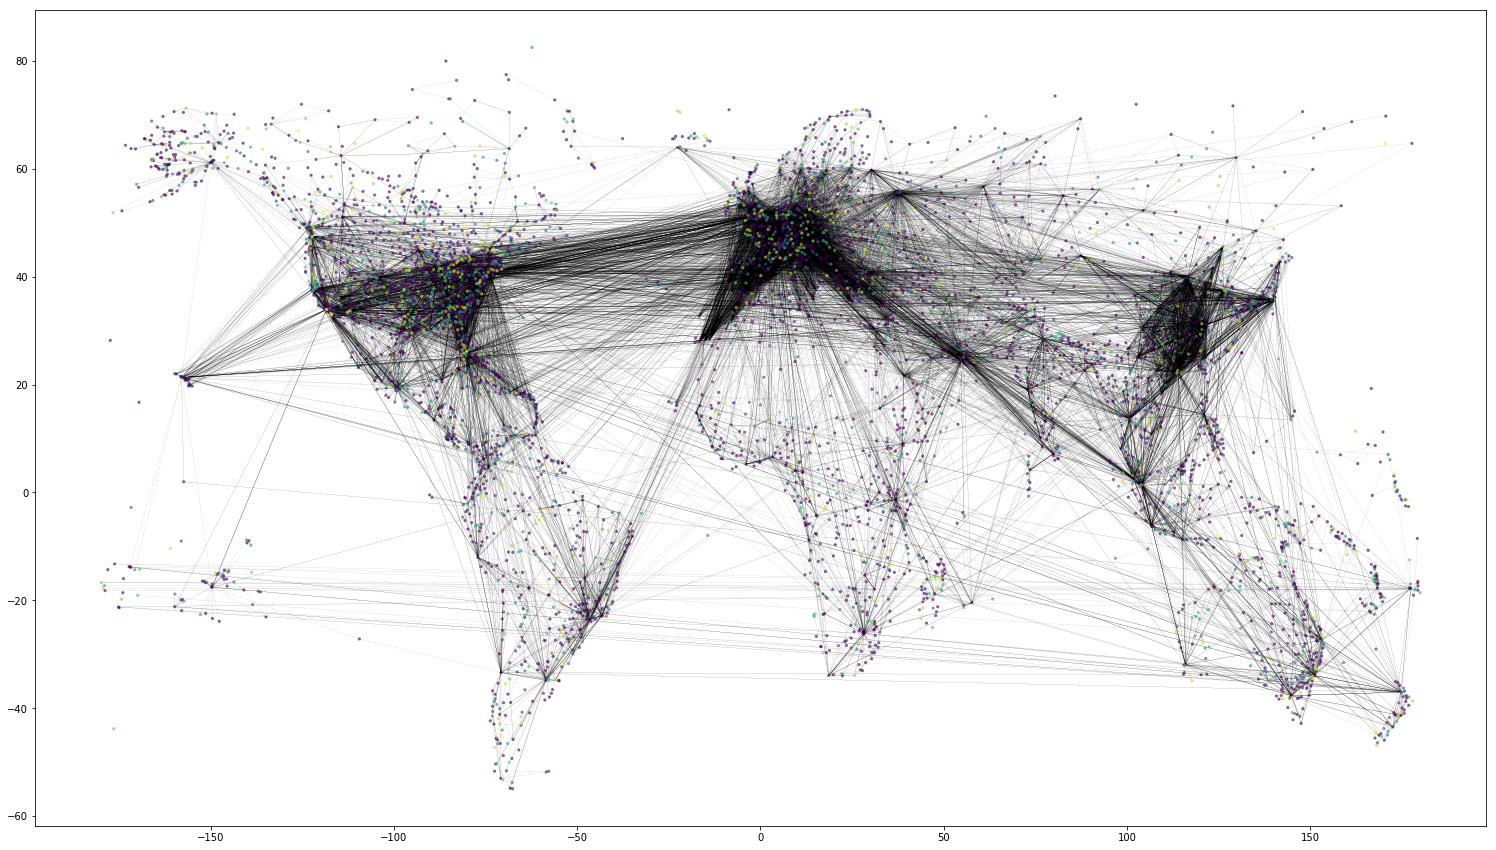

In [22]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph.to_undirected(), positions, 
                 width=0.1,alpha=0.5,node_size=5,with_labels=False, 
                 node_color = values, ax=fig.add_subplot(111))

fig.savefig("output/airportgraph_communities.png", transparent=True)

## Communities by Continent

**Preparing the data**

In [23]:
countriescontinents_df = pd.read_csv("data/CountriesContinents.csv")

In [24]:
countriescontinents_df.set_index(['Country','Continent']);

In [25]:
airports_continents = airports_df.merge(countriescontinents_df,on="Country",how="inner")

In [26]:
airports_continents_by_continent = airports_continents.groupby("Continent")
continents = list(airports_continents_by_continent.groups)


In [27]:
eur_df = list(airports_continents.loc[airports_continents['Continent'] == 'Europe'].groupby('IATA').groups);
oce_df = list(airports_continents.loc[airports_continents['Continent'] == 'Oceania'].groupby('IATA').groups);
afr_df = list(airports_continents.loc[airports_continents['Continent'] == 'Africa'].groupby('IATA').groups);
asia_df = list(airports_continents.loc[airports_continents['Continent'] == 'Asia'].groupby('IATA').groups);
na_df = list(airports_continents.loc[airports_continents['Continent'] == 'North America'].groupby('IATA').groups);
sa_df = list(airports_continents.loc[airports_continents['Continent'] == 'South America'].groupby('IATA').groups);

In [28]:
def calculateLC(graph,community_df):
    lc = 0
    for node in list(graph.nodes()):
        if node in community_df:
            lc += len([i for i in graph.neighbors(node) if i in community_df])
        
    return lc/2.0

def calculateKC(graph,community_df):
    return sum([graph.degree(node) for node in community_df])
    
def Mc(G,commmunity_df):
    return (calculateLC(G,commmunity_df)/len(G.edges()))-(calculateKC(G,commmunity_df)/(2*len(G.edges())))**2


**Calculating modularity**

In [29]:
#['Europe', 'Oceania', 'Africa', 'Asia', 'North America', 'South America']

modularity = Mc(airport_routes_digraph,eur_df) + Mc(airport_routes_digraph,oce_df) + Mc(airport_routes_digraph,afr_df) + Mc(airport_routes_digraph,asia_df) + Mc(airport_routes_digraph,na_df) + Mc(airport_routes_digraph,sa_df)

In [30]:
modularity 

0.23643599246612798

**Commenting on modularity**

When dividing the different continents into different communities, a modularity that is almost as high as the optimal community partition modularity. Even though the modularity is not very high, i.e. sub-optimal, it is positive that using continents as communities is close to the best possible community partition. 

It would make sense that partitioning by continent would create a sub-optimal community partition. Continents tend to have a fair amount of flights going within the continent, due to the physical size of the continents. This is also visible in the various plots. There are however still many intercontinental flights, which heavily lowers the modularity which is also why it is hard to find a good community partition. The different airports around the world are simply very well interconnected.

**Community plot**

In [31]:
nodeColors = []
for node in airport_routes_digraph.nodes:
    continent = list(airports_continents.loc[airports_continents['IATA'] == node]['Continent'])[0]
    
    if continent == 'Asia':
        nodeColors.append('red')
    elif continent == 'Europe':
        nodeColors.append('blue')
    elif continent == 'Oceania':
        nodeColors.append('cyan')
    elif continent == 'Africa':
        nodeColors.append('pink')
    elif continent == 'North America':
        nodeColors.append('green')
    elif continent == 'South America':
        nodeColors.append('yellow')    
    else:
        nodeColors.append('brown')

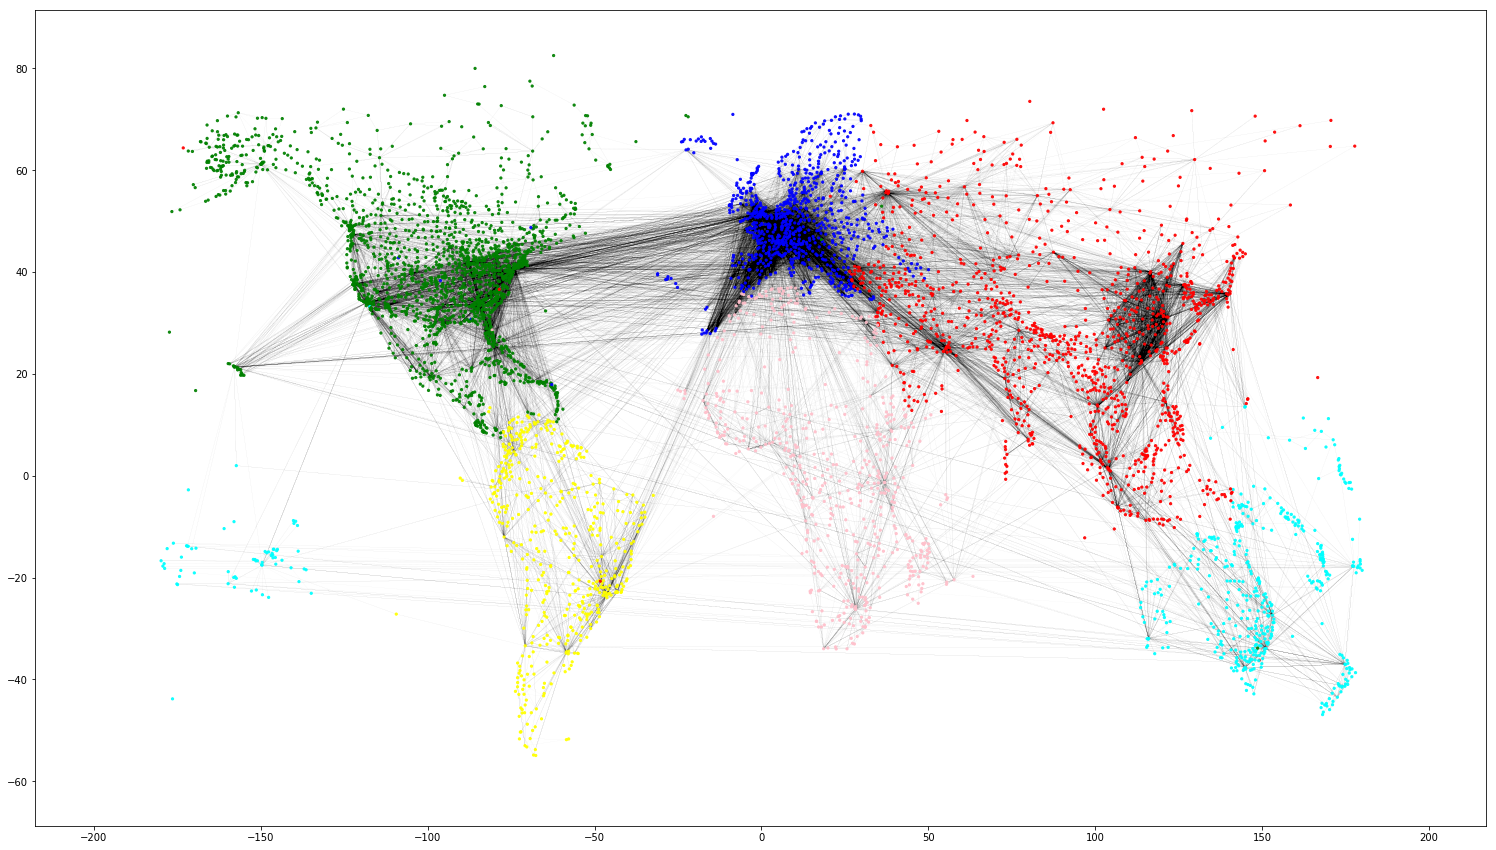

In [32]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.01,alpha=0.9,node_size=5,with_labels=False, 
                 node_color = nodeColors, ax=fig.add_subplot(111),arrowstyle='-')

fig.savefig("output/airportgraph_continent_communities.png", transparent=True)

# Communities by Countries

**Calculating modularity**

In [33]:
countries = list(airports_df.groupby('Country').groups)

In [34]:
country_dfs = []

In [35]:
for country in countries:
    country_dfs.append((country,list(airports_df.loc[airports_df['Country'] == country].groupby('IATA').groups)))

In [36]:
country_by_modularity =  [(c[0],Mc(airport_routes_digraph,c[1])) for c in country_dfs]
country_com_modularity = sum([Mc(airport_routes_digraph,c[1]) for c in country_dfs])

In [37]:
print(country_com_modularity)

0.130468132936


In [38]:
countries_sort_by_mod = sorted(country_by_modularity,key = lambda (k,v):(v,k),reverse=True)
top_10_country_mod = countries_sort_by_mod[:10]
bot_10_country_mod = countries_sort_by_mod[-10:]

print("Top 10:")
print(top_10_country_mod)
print(" ")
print("Bottom 10:")
print(bot_10_country_mod)

Top 10:
[('United States', 0.04124643052433319), ('China', 0.020011847621362173), ('Canada', 0.006212406586062337), ('Brazil', 0.005323834983899386), ('Russia', 0.005141563886019807), ('Australia', 0.0033492314235372745), ('Japan', 0.002642930919253904), ('India', 0.0026049577738623247), ('Mexico', 0.002430281305061061), ('France', 0.002369524272434534)]
 
Bottom 10:
[('Belarus', 0.0), ('Barbados', 0.0), ('Bahrain', 0.0), ('Aruba', 0.0), ('Armenia', 0.0), ('Antigua and Barbuda', 0.0), ('Antarctica', 0.0), ('Anguilla', 0.0), ('American Samoa', 0.0), ('Albania', 0.0)]


**Commenting on modularity**

The modularity when creating communities based on countries is very low. This makes sense, since most countries are not very big and do not have a lot of domestic flights. Therefore many of outgoing flights from those countries are international. The bigger countries should be more ideal as a community, since their vast area would imply more domestic flights, but there aren't that many very large countries and  they too have large international airports connecting the country to other contintents. This is also exactly what can be noted by looking at the top 10 and bottom 10 countries by their contribution to the modularity of the whole community. The bottom 10 are smaller countries, and in many cases small islands, which further proves the above statement.

**Community plot**

In [39]:
countrylabels = []
for node in airport_routes_digraph.nodes():
    countrylabels.append(countries.index(list(airports_df.loc[airports_df['IATA'] == node]['Country'])[0]))

In [40]:
colors = list(map(plt.cm.get_cmap('hsv', len(set(countries))+1),countrylabels))

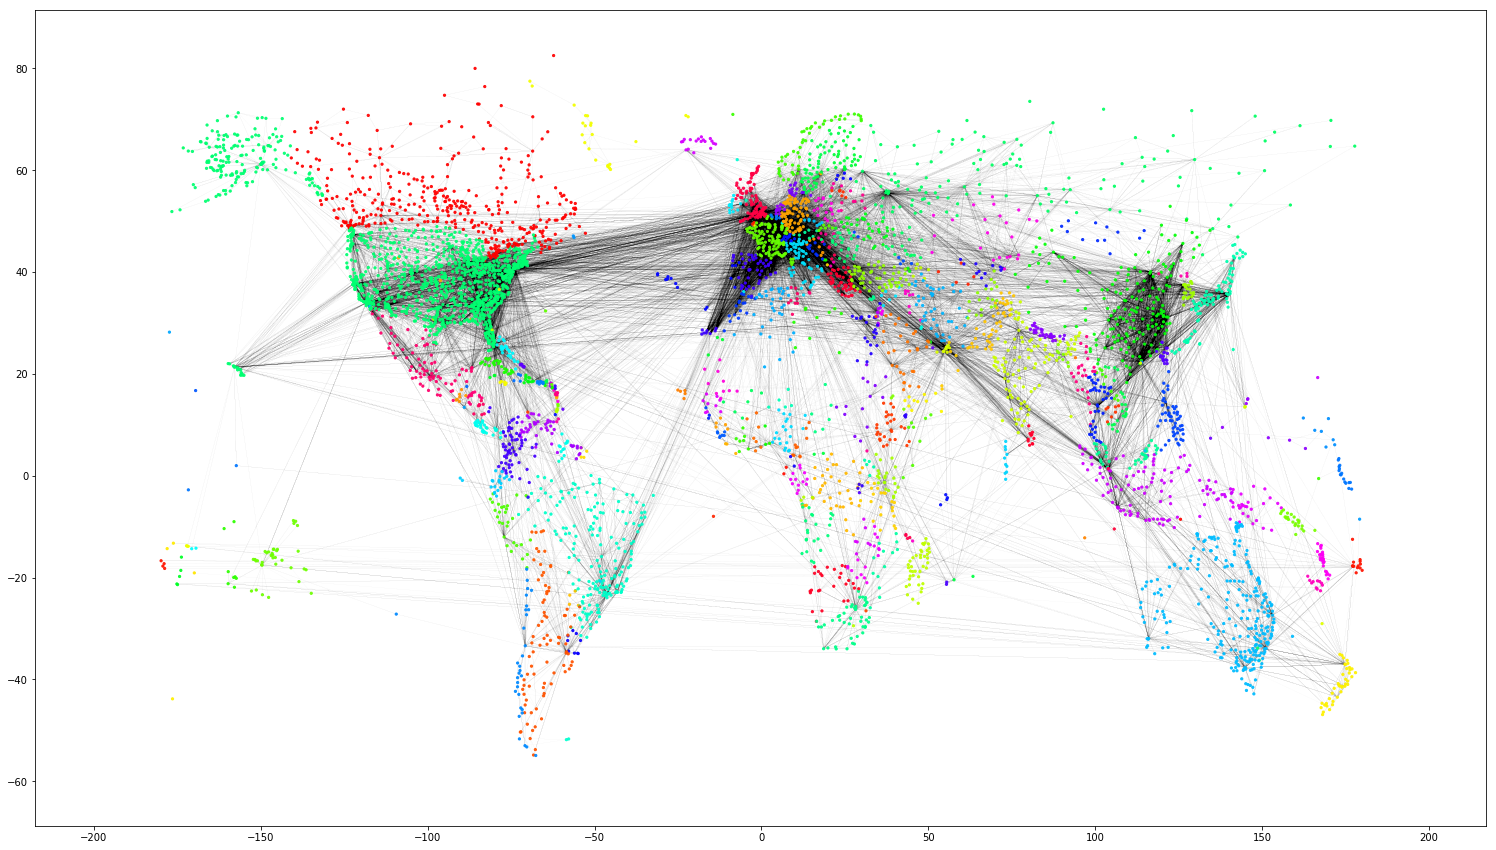

In [41]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.01,alpha=0.9,node_size=5,with_labels=False, 
                 node_color = colors, ax=fig.add_subplot(111),arrowstyle='-')

fig.savefig("output/airportgraph_country_communities.png", transparent=True)

# Further Community Analysis

It was chosen also to analyze, whether hub airports tend to connect communities together. Here we're keeping the community partition using continents in mind, since it makes more sense to analyze that partition, than the best partition which at a quick glance is nonsensical.

In [42]:
#The following hubs are found based on degree.
hubs = ['Hartsfield Jackson Atlanta International Airport',"Chicago O'Hare International Airport",
        'Beijing Capital International Airport','Charles de Gaulle International Airport',
        'London Heathrow Airport','Los Angeles International Airport',
        'Frankfurt am Main International Airport','Amsterdam Airport Schiphol',
        'Dallas Fort Worth International Airport','John F Kennedy International Airport']

In [43]:
nodesizes = []
nodeColors = []

#Hubs are colored xxx and a given a larger size than the remaining airports.
for node in airport_routes_digraph.nodes:
    continent = list(airports_continents.loc[airports_continents['IATA'] == node]['Continent'])[0]
    if (list(airports_df.loc[airports_df['IATA'] == node]['Name'])[0] in hubs):
            nodeColors.append('red')
            nodesizes.append(100)
    else:        
        nodesizes.append(2)
        if continent == 'Asia':
            nodeColors.append('purple')
        elif continent == 'Europe':
            nodeColors.append('blue')
        elif continent == 'Oceania':
            nodeColors.append('cyan')
        elif continent == 'Africa':
            nodeColors.append('pink')
        elif continent == 'North America':
            nodeColors.append('green')
        elif continent == 'South America':
            nodeColors.append('yellow')    
        else:
            nodeColors.append('brown')

In [ ]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.1,alpha=0.9,node_color=nodeColors,node_size=nodesizes,with_labels=False, 
                 ax=fig.add_subplot(111))

fig.savefig("output/airportgraph_with_high_degree_hubs.png", transparent=True)

In [45]:
for node in hubs:
    print(node)
    iata = list(airports_continents.loc[airports_continents['Name'] == node]['IATA'])[0]
    print(airport_routes_digraph.out_edges(iata))

Hartsfield Jackson Atlanta International Airport
[('ATL', 'JFK'), ('ATL', 'JFK'), ('ATL', 'JFK'), ('ATL', 'JFK'), ('ATL', 'JFK'), ('ATL', 'JFK'), ('ATL', 'JFK'), ('ATL', 'JFK'), ('ATL', 'JFK'), ('ATL', 'JFK'), ('ATL', 'GSP'), ('ATL', 'GSP'), ('ATL', 'GSP'), ('ATL', 'GSP'), ('ATL', 'FNT'), ('ATL', 'FNT'), ('ATL', 'FNT'), ('ATL', 'ROC'), ('ATL', 'ROC'), ('ATL', 'ROC'), ('ATL', 'ROC'), ('ATL', 'MIA'), ('ATL', 'MIA'), ('ATL', 'MIA'), ('ATL', 'MIA'), ('ATL', 'MIA'), ('ATL', 'MIA'), ('ATL', 'MIA'), ('ATL', 'MIA'), ('ATL', 'MIA'), ('ATL', 'MIA'), ('ATL', 'MIA'), ('ATL', 'MIA'), ('ATL', 'LIM'), ('ATL', 'BOS'), ('ATL', 'BOS'), ('ATL', 'BOS'), ('ATL', 'BOS'), ('ATL', 'BOS'), ('ATL', 'BOS'), ('ATL', 'BOS'), ('ATL', 'BOS'), ('ATL', 'FWA'), ('ATL', 'FWA'), ('ATL', 'FWA'), ('ATL', 'FWA'), ('ATL', 'CCS'), ('ATL', 'LIT'), ('ATL', 'LIT'), ('ATL', 'LIT'), ('ATL', 'LIT'), ('ATL', 'NAS'), ('ATL', 'NAS'), ('ATL', 'NAS'), ('ATL', 'NAS'), ('ATL', 'YUL'), ('ATL', 'YUL'), ('ATL', 'YUL'), ('ATL', 'BON'), ('ATL'

Considering the plot above, the red plots are the hubs that were defined. What could be considered is whether or not the hubs tend to be links between communities. This has to be the case. Due to the fact that a given node is a hub, must also indicate that this node will be connected communities together. It could be the case that the hub only connects with other nodes in the same community. However, in this case we're dealing with airports and when using continents as a partioning, it will lead to the hubs connecting communities together.